# Advanced network consolidation

1. consolidate intersections
2. consolidate edges

In [1]:
from itertools import combinations
import collections

import pygeos
import numpy as np
import pandas as pd
import geopandas as gpd
import momepy as mm
import osmnx as ox

from shapely.ops import polygonize
from scipy.spatial import Voronoi

from consolidate import *

In [75]:
point = (30.027555, -95.615635)
dist = 2000

streets_graph = ox.graph_from_point(point, dist, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)

<AxesSubplot:>

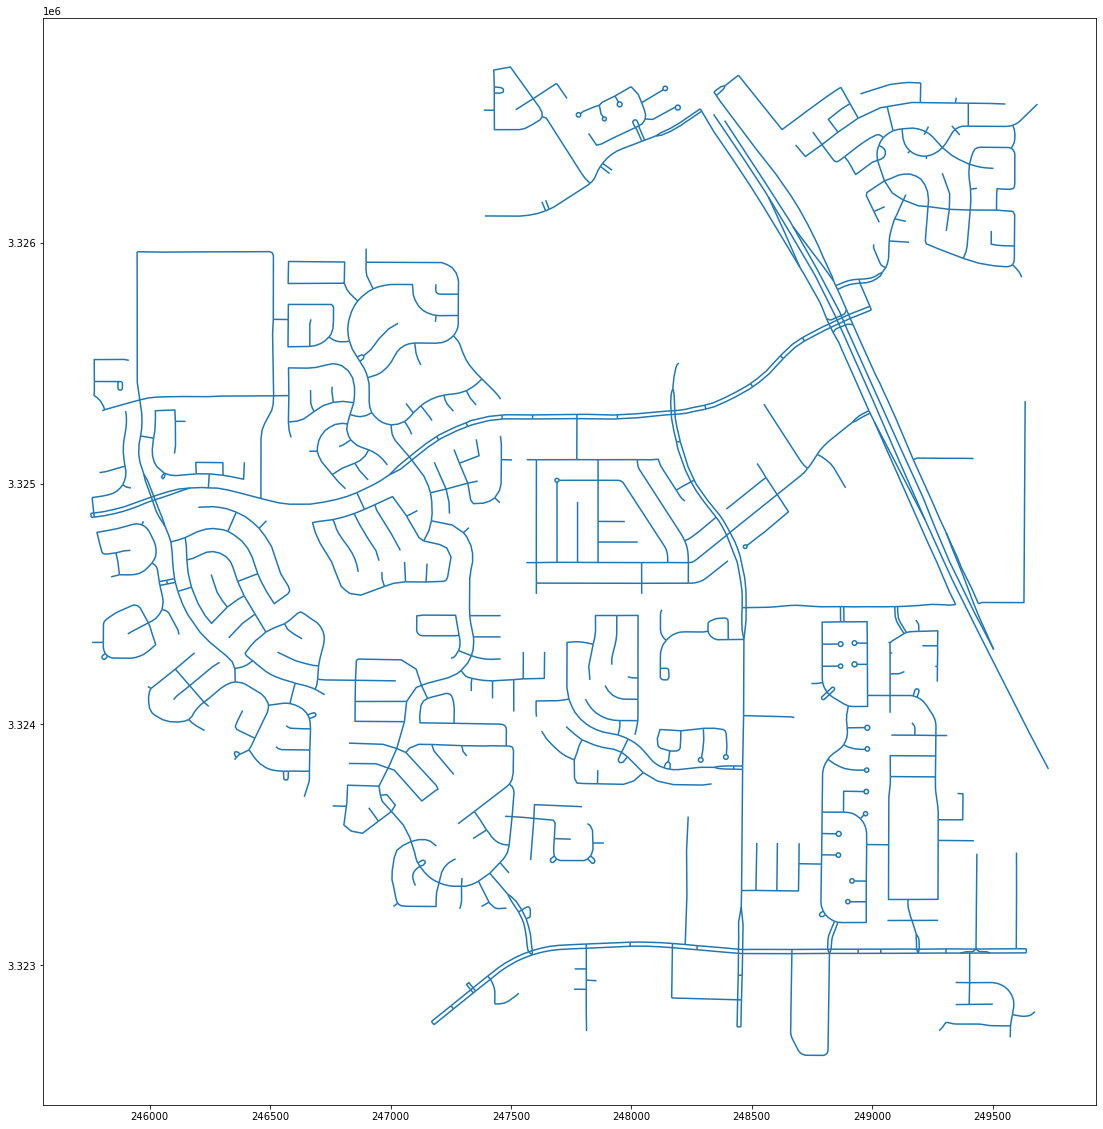

In [76]:
gdf.plot(figsize=(20, 20))

In [78]:
def consolidate_nodes(gdf, tolerance):
    """ Return geoemtry with consolidated nodes.
    
    Replace clusters of nodes with a single node (weighted centroid
    of a cluster) and snap linestring geometry to it. Cluster is 
    defined using DBSCAN on coordinates with ``tolerance``==``eps`.
    
    Does not preserve any attributes, function is purely geometric.
    
    Parameters
    ----------
    gdf : GeoDataFrame
        GeoDataFrame with LineStrings (usually representing street network)
    tolerance : float
        The maximum distance between two nodes for one to be considered 
        as in the neighborhood of the other. Nodes within tolerance are
        considered a part of a single cluster and will be consolidated.
        
    Returns
    -------
    GeoSeries
    """
    from sklearn.cluster import DBSCAN

    # get nodes and edges
    G = mm.gdf_to_nx(gdf)
    nodes, edges = mm.nx_to_gdf(G)
    
    # get clusters of nodes which should be consolidated
    db = DBSCAN(eps=tolerance, min_samples=2).fit(pygeos.get_coordinates(nodes.geometry.values.data))
    nodes['lab'] = db.labels_
    nodes['lab'] = nodes['lab'].replace({-1: np.nan})  # remove unassigned nodes
    change = nodes.dropna().set_index('lab').geometry

    # get pygeos geometry
    geom = edges.geometry.values.data
    
    # loop over clusters, cut out geometry within tolerance / 2 and replace it
    # with spider-like geometry to the weighted centroid of a cluster
    spiders = []
    midpoints = []
    for cl in change.index.unique():
        cluster = change.loc[cl] 
        cookie = pygeos.from_shapely(cluster.buffer(tolerance / 2).unary_union)
        inds = pygeos.STRtree(geom).query(cookie, predicate='intersects')
        pts = pygeos.get_coordinates(pygeos.intersection(geom[inds], pygeos.boundary(cookie)))
        geom[inds] = pygeos.difference(geom[inds], cookie)
        if pts.shape[0] > 0:
            midpoint = np.mean(pygeos.get_coordinates(cluster.values.data), axis=0)
            midpoints.append(midpoint)
            mids = np.array([midpoint,] * len(pts))
            spider = pygeos.linestrings(np.array([pts[:, 0], mids[:, 0]]).T, y=np.array([pts[:, 1], mids[:, 1]]).T)
            spiders.append(spider)
    
    # combine geometries
    geometry = np.append(geom, np.hstack(spiders))
    geometry = geometry[~pygeos.is_empty(geometry)]
    
    midpoints = gpd.GeoSeries(pygeos.points(midpoints), crs=gdf.crs)
    return gpd.GeoSeries(geometry, crs=gdf.crs), midpoints

In [79]:
%%time
consolidated, midpoints = consolidate_nodes(gdf, 20)

CPU times: user 476 ms, sys: 6.6 ms, total: 483 ms
Wall time: 482 ms


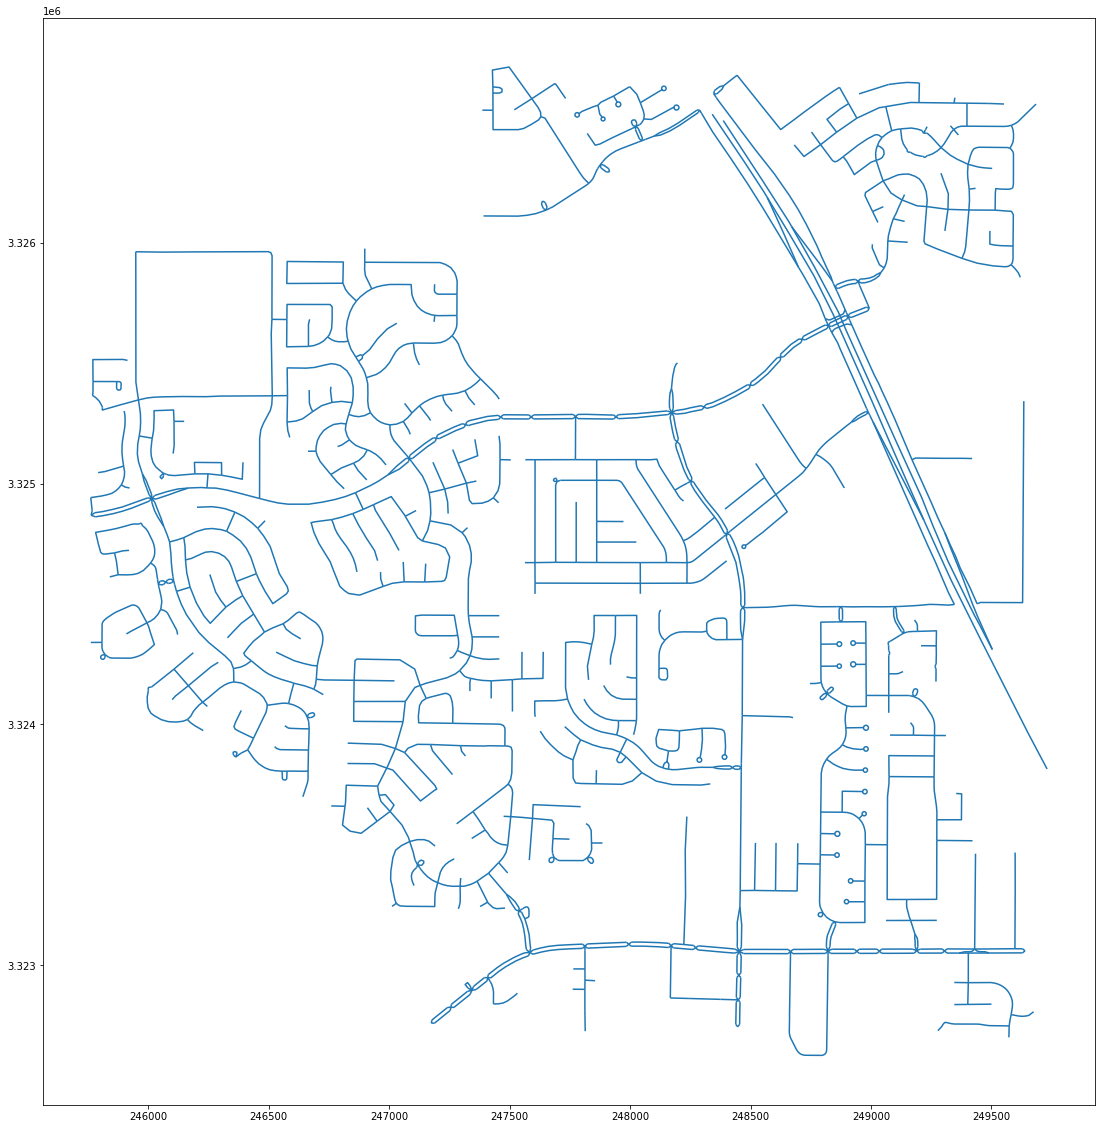

In [81]:
ax=consolidated.plot(figsize=(20, 20))
# midpoints.plot(ax=ax, color='r')

In [82]:
polygonized = polygonize(consolidated.geometry.unary_union)
geoms = [g for g in polygonized]
poly = gpd.GeoDataFrame(geometry=geoms, crs=consolidated.crs)

<AxesSubplot:>

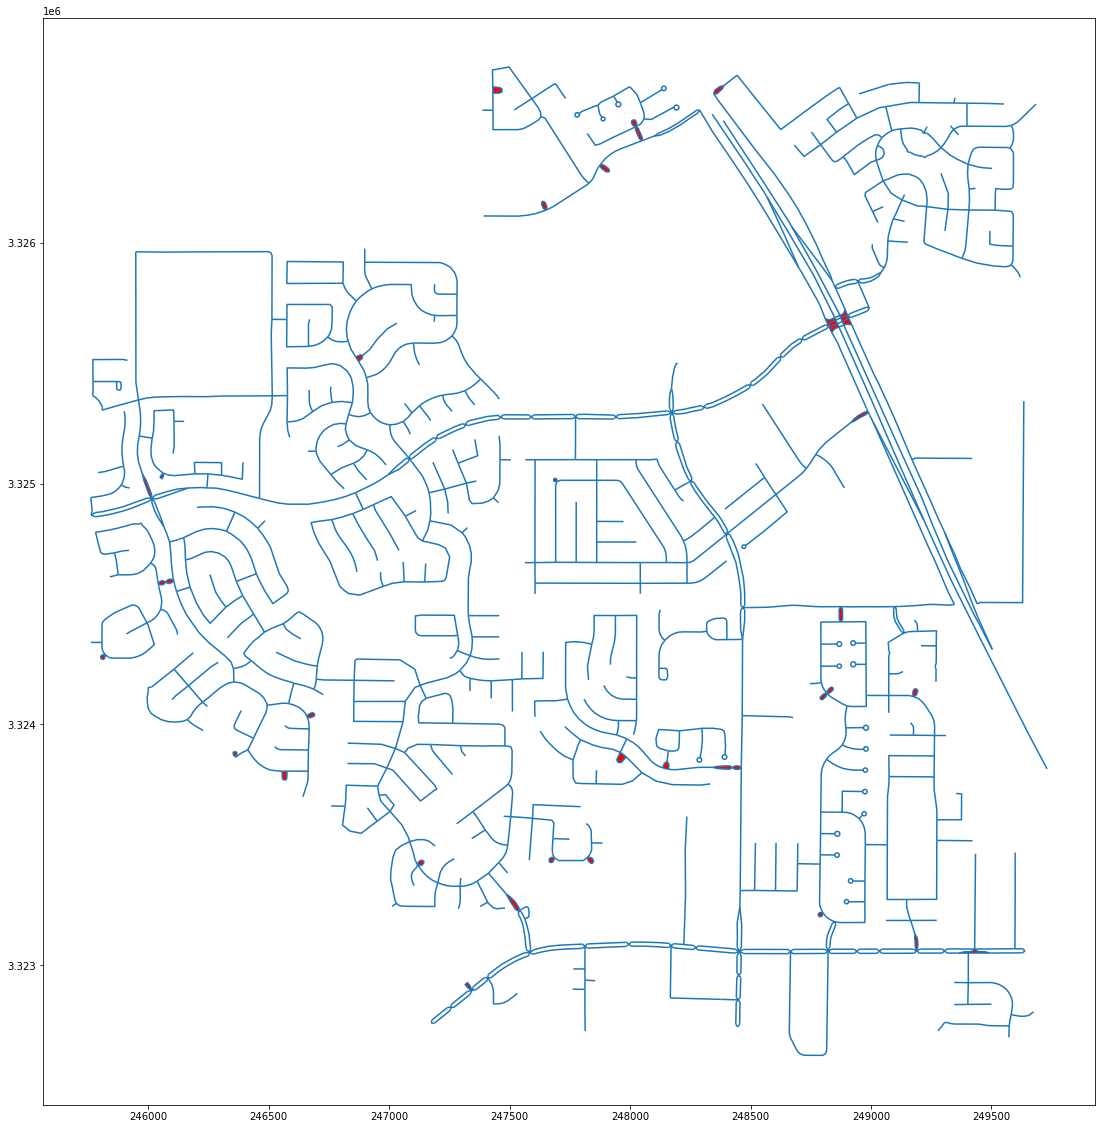

In [92]:
ax=consolidated.plot(figsize=(20, 20))
poly[filter_small(poly, consolidated)].plot(ax=ax, color='r')

In [77]:
gdf[['geometry']].to_file('temp.gpkg', driver='GPKG', layer='orig_undir')

<AxesSubplot:>

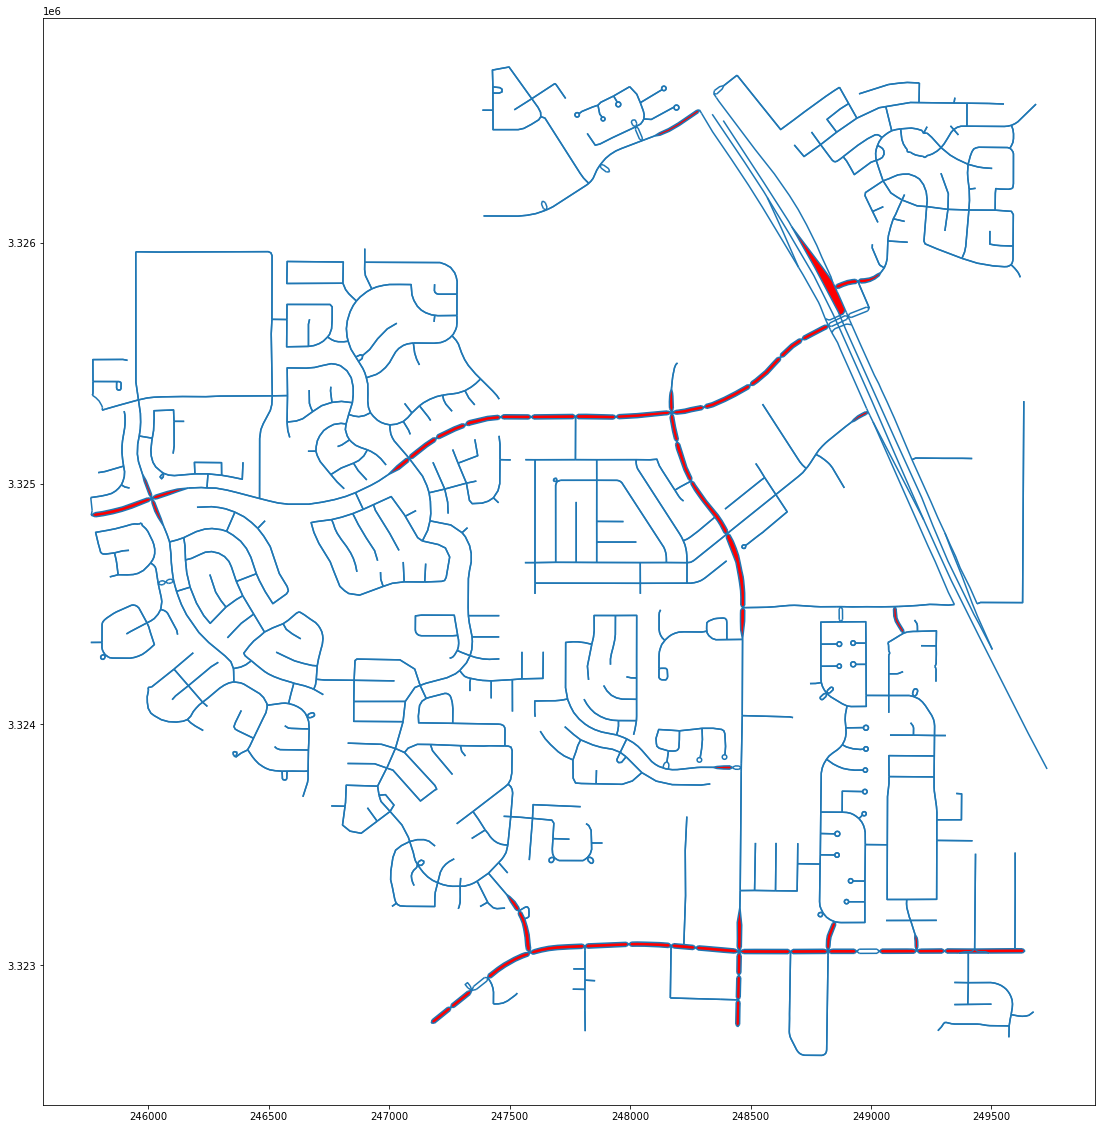

In [8]:
ax = consolidated.plot(figsize=(20, 20))
poly[filter_comp(poly, 10000, .2)].plot(ax=ax, color='r')

In [93]:
fixed_topo = topology(consolidated)

In [94]:
first = consolidate(fixed_topo, filter_func=filter_comp)

<AxesSubplot:>

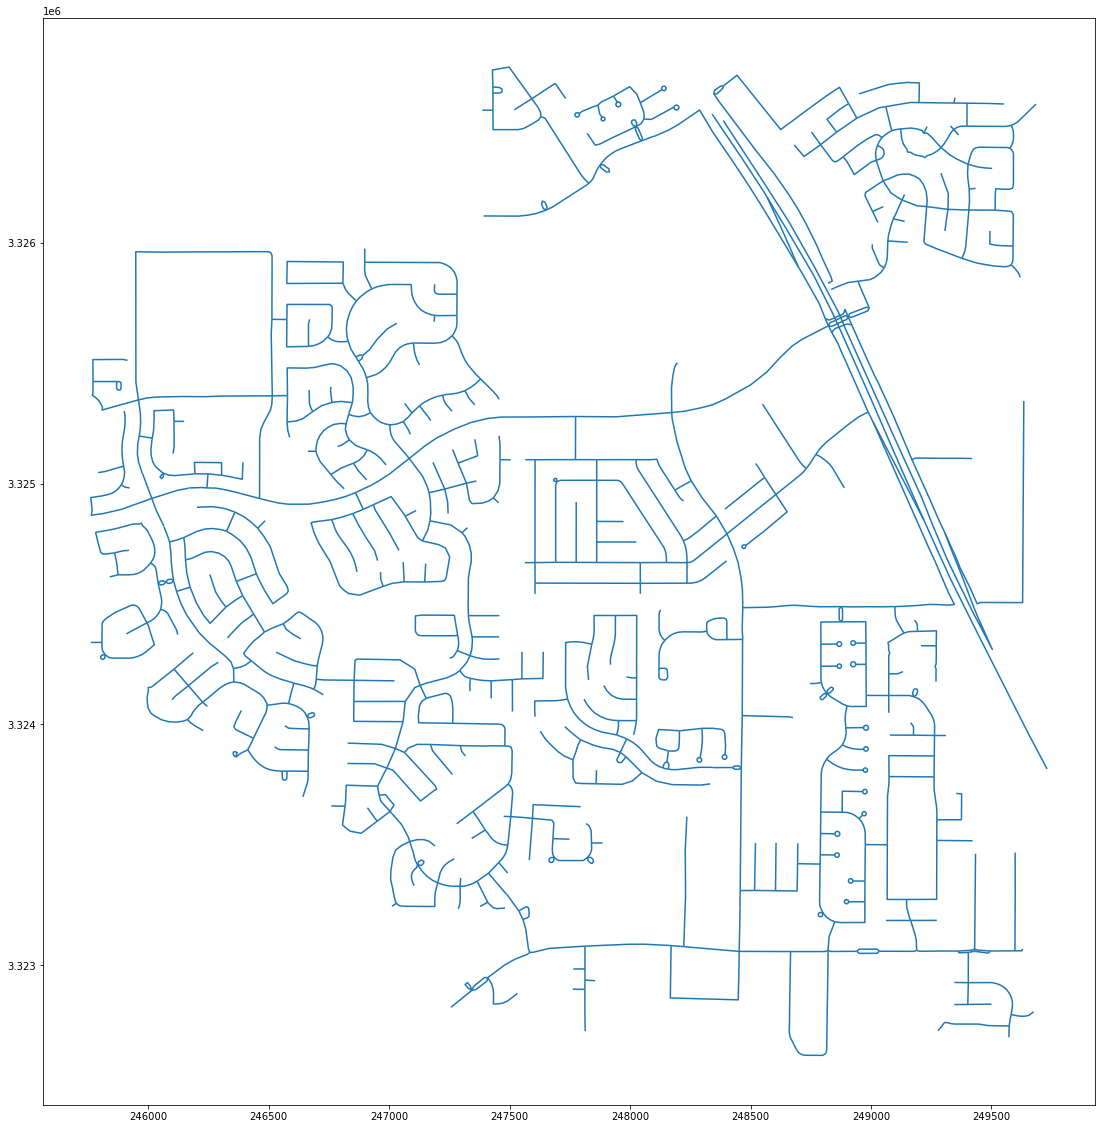

In [95]:
first.plot(figsize=(20, 20))

In [103]:
def filter_small(gdf, network_, max_size=1000):
    small = gdf[gdf.area < max_size]
    inp, res = pygeos.STRtree(small.geometry.values.data).query_bulk(network_.geometry.values.data, predicate='covered_by')
    unique, counts = np.unique(res, return_counts=True)
    return gdf.index.isin(small.iloc[unique[counts>1]].index)

In [104]:
second = consolidate(first, filter_func=filter_small, network_=first)

<AxesSubplot:>

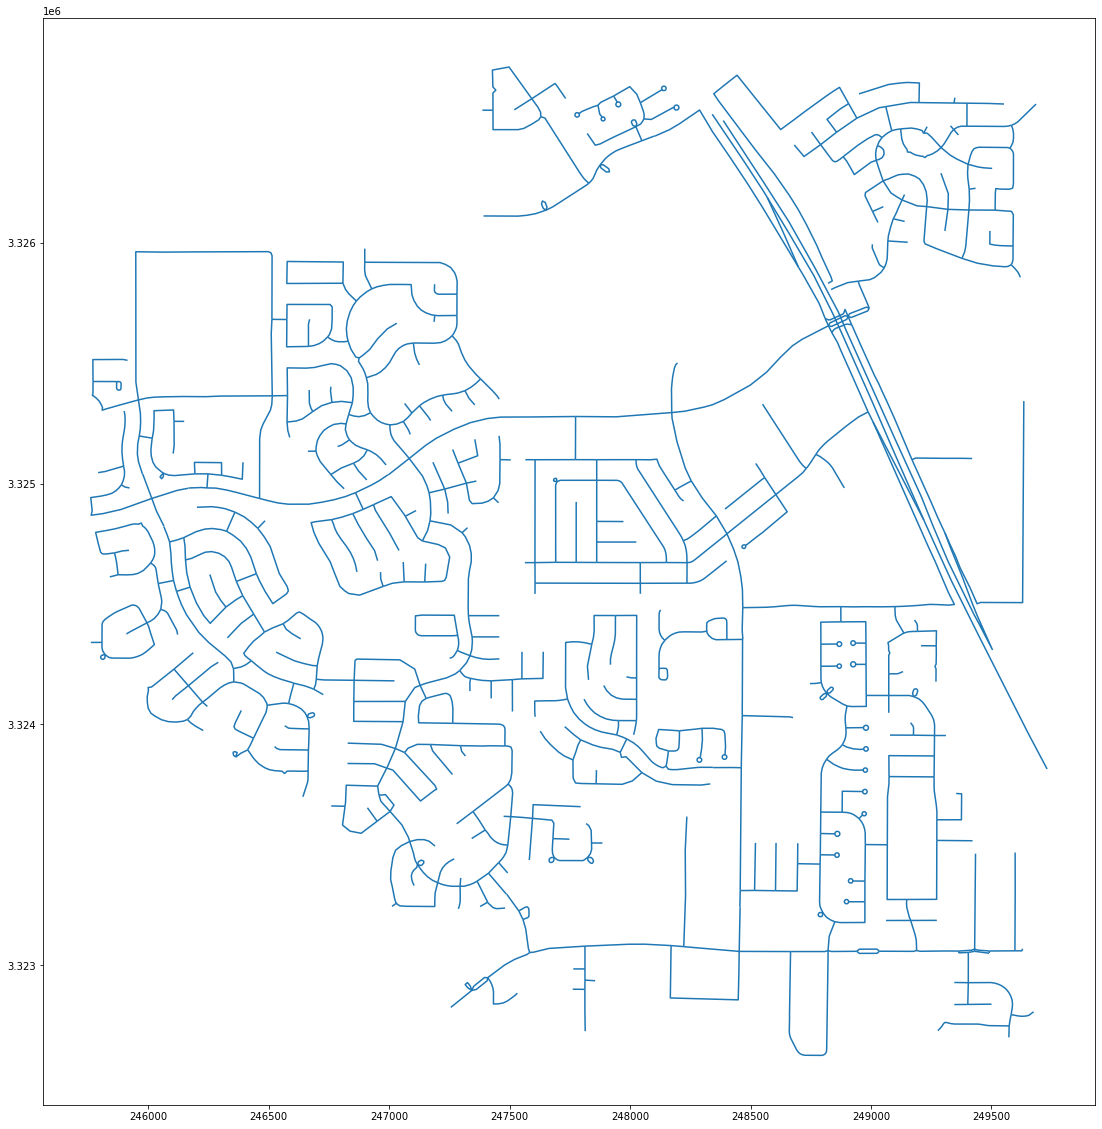

In [105]:
second.plot(figsize=(20, 20))

<AxesSubplot:>

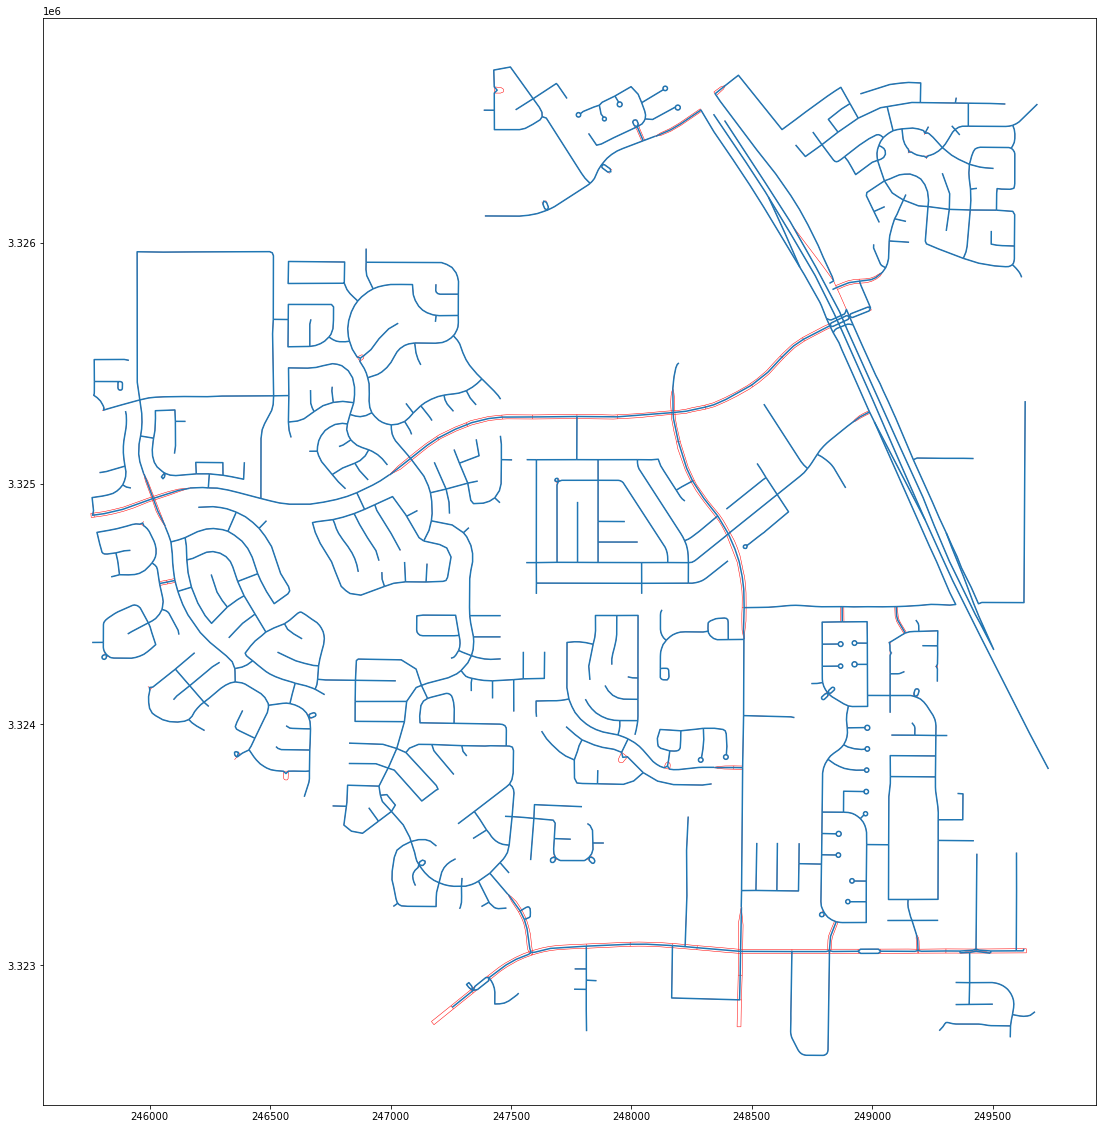

In [108]:
ax = gdf.plot(figsize=(20, 20), color='r', zorder=0, linewidth=.5)
second.plot(ax=ax,zorder=1)